In [29]:
%pip install matplotlib seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
import pandas as pd

df = pd.read_csv('output/k6-lint-results.csv')
# limpar nomes das colunas
df.columns = df.columns.str.lower().str.strip()


# limpar valores string em todas as colunas do tipo object
df = df.apply(lambda col: col.str.lower().str.strip() if col.dtype == "object" else col)

# mostrar formato final
df.shape

(3073, 13)

In [61]:
# Remove arquivos que não conseguiu clonar
df = df[df['file_exists'] != 'yes']

# Remove as colunas que não importam
df.drop(columns=['url','file_exists','clone_error'], inplace=True)
df

,repositório,arquivo,k6-performance/no-heavy-init-context,k6-performance/no-heavy-init-context_loc,k6-performance/require-check,k6-performance/require-check_loc,k6-performance/require-tags,k6-performance/require-tags_loc,k6-performance/require-thresholds,k6-performance/require-thresholds_loc
1052,propanec3h8/taskmanager,loadtest/tasks_k6.js,0,,0,,0,,0,


In [32]:
# df = df[(df['k6-performance/no-heavy-init-context'] != 0) | (df['k6-performance/require-check'] != 0) | (df['k6-performance/require-tags'] != 0) | (df['k6-performance/require-thresholds'] != 0)]

#Adiciona uma coluna com o total de smells em cada repositorio
violation_cols = [c for c in df.columns if c.startswith('k6-performance/') and not c.endswith('_loc')]
df['total_violations'] = df[violation_cols].sum(axis=1)

#remove repositorios sem smell
# df = df[df['total_violations'] > 0]

df.shape

(3072, 11)

In [33]:
# agregações básicas: soma de violações por repositório
violations_by_repo = df.groupby('repositório')['total_violations'].sum().sort_values(ascending=False).head(20)
violations_by_repo

repositório
criscarlolm/k6-kubernetes-aws-loadtest      459
petechain23/k6                              340
nicolevanderhoeven/k6-scripts               301
firmansyah-github/quarkus-generated-test    209
lucascnasc/k6-petstore                      176
icescout26/swagger-petstore-sqa             142
arn-ob/script-load-testing                  116
timpamungkasudemy/ai-assisted-testing-k6    105
trangle-sioux/k6-performance                101
spryker/commerce-k6-performance-tests        99
edusoftpro/js-k6                             93
woocommerce/woocommerce                      86
notmattpress/poocommerce                     86
urumiai/starshop                             86
urumiai/wc-perf-testing                      86
sipe-team/3-1_spurt                          84
vunetsystems/load-testing-tool               84
matfritzen/k6-tests                          83
agussyahrilmubarok/course-assignments        77
chris-owusu/k6                               76
Name: total_violations, dtyp

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('output/img', exist_ok=True)
IMG_OUTPUT_FOLDER = 'output/img/'
# garante que a pasta de saída exista (não redefine IMG_OUTPUT_FOLDER)
os.makedirs(IMG_OUTPUT_FOLDER, exist_ok=True)

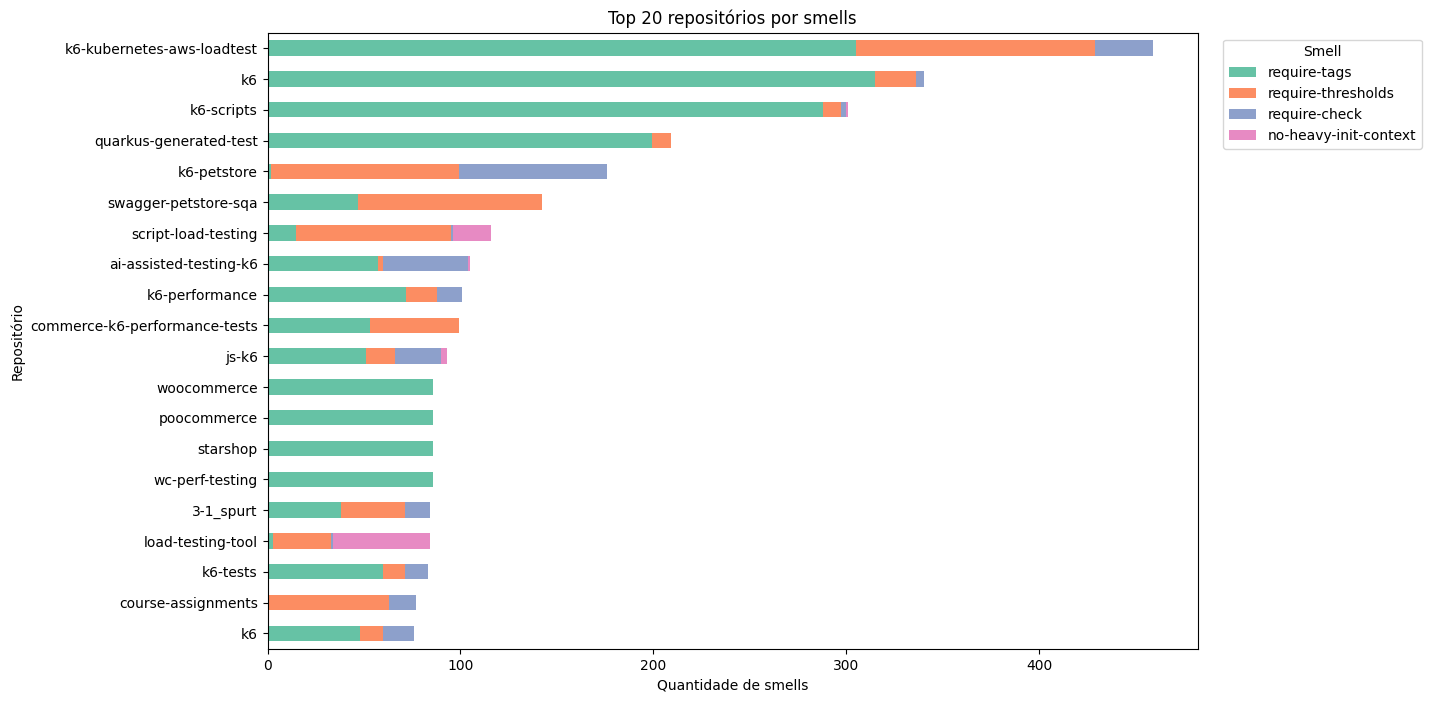

In [35]:
# Gráfico de barras empilhadas com as 4 smells mais comuns por repositório
top_repos = violations_by_repo.index.tolist()  # top 20 já calculados em cell 4

# Seleciona as 4 smells mais comuns (recalcula para garantir que existe)
top_4_smells = df[violation_cols].sum().sort_values(ascending=False).head(4).index.tolist()

# Agrega soma de cada smell por repositório, mantendo a ordem dos top repos
stacked_df = df[df['repositório'].isin(top_repos)].groupby('repositório')[top_4_smells].sum().loc[top_repos]

# nomes limpos para legendas/labels
clean_names = [s.replace('k6-performance/', '') for s in top_4_smells]

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Set2.colors[:len(top_4_smells)]  # paleta de cores

# plot horizontal empilhado (cada coluna uma smell)
stacked_df.plot(kind='barh', stacked=True, ax=ax, color=colors)

ax.set_xlabel('Quantidade de smells')
ax.set_ylabel('Repositório')
ax.set_title('Top 20 repositórios por smells')
# tornar rótulos mais legíveis
labels = [r.split('/', 1)[1] if '/' in r else r for r in stacked_df.index]
ax.set_yticklabels(labels)
plt.gca().invert_yaxis()  # manter maior no topo

# legenda com nomes limpos
ax.legend(clean_names, title='Smell', bbox_to_anchor=(1.02, 1), loc='upper left')

# plt.tight_layout()
output_file = os.path.join(IMG_OUTPUT_FOLDER, 'smells_by_repo.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

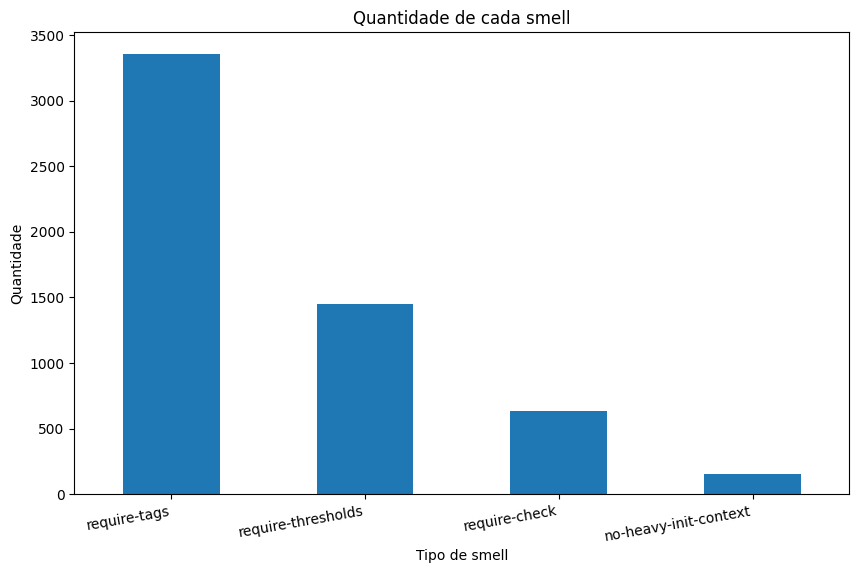

In [36]:
smell_counts = df[violation_cols].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
smell_counts.plot(kind='bar', ax=ax)
ax.set_title('Quantidade de cada smell')
ax.set_xlabel('Tipo de smell')
ax.set_ylabel('Quantidade')
ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()], rotation=10, ha='right')
# fig.tight_layout()
plt.show()
fig.savefig(IMG_OUTPUT_FOLDER + 'smell_counts.png', dpi=300, bbox_inches='tight')
plt.close(fig)

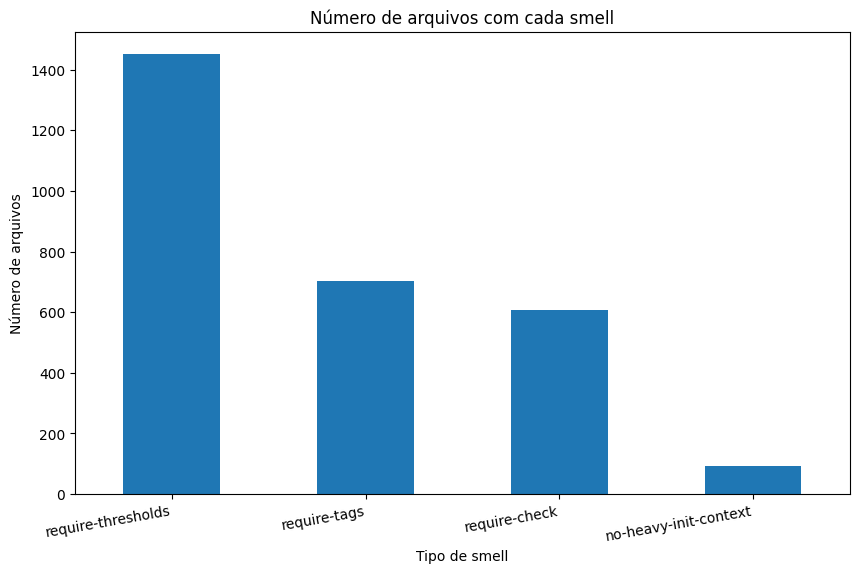

In [37]:
# Contar número de arquivos (linhas) que apresentam cada smell
# Para cada coluna de smell, conta quantas linhas têm valor > 0
smell_file_counts = (df[violation_cols] > 0).sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
smell_file_counts.plot(kind='bar', ax=ax)
ax.set_title('Número de arquivos com cada smell')
ax.set_xlabel('Tipo de smell')
ax.set_ylabel('Número de arquivos')
# Ajusta rótulos removendo o prefixo 'k6-performance/' para ficar mais legível
ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()], rotation=10, ha='right')
# fig.tight_layout()
plt.show()
fig.savefig(IMG_OUTPUT_FOLDER + 'smell_files_count.png', dpi=300, bbox_inches='tight')
plt.close(fig)

/tmp/ipykernel_29508/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


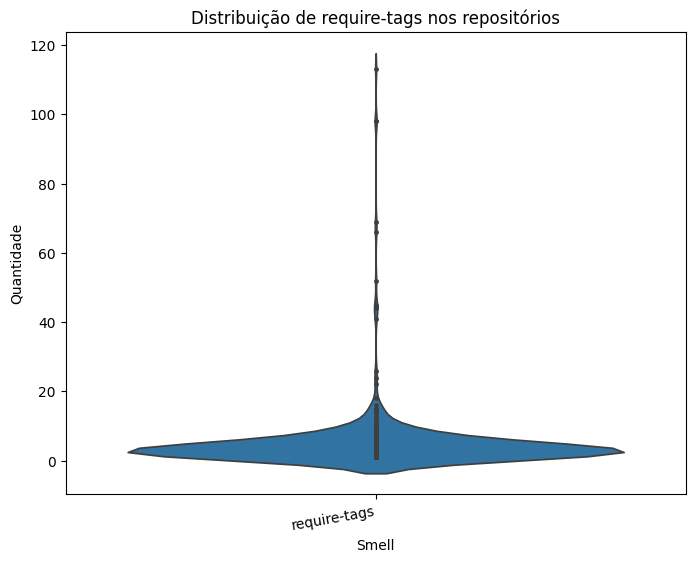

/tmp/ipykernel_29508/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


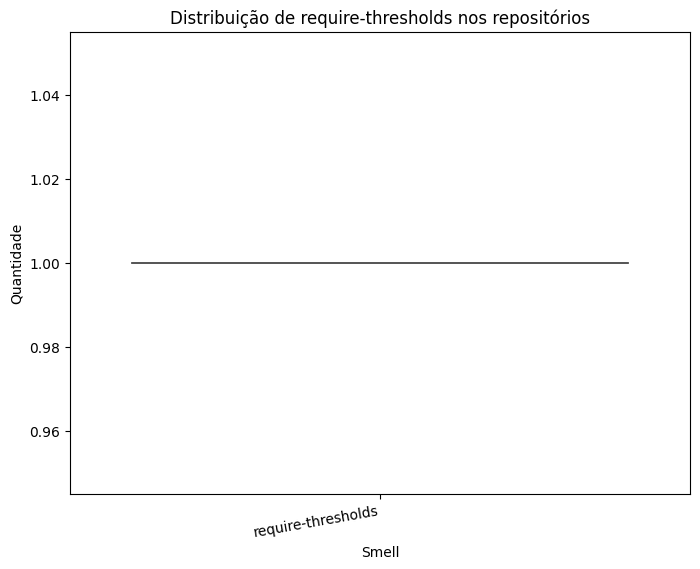

/tmp/ipykernel_29508/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


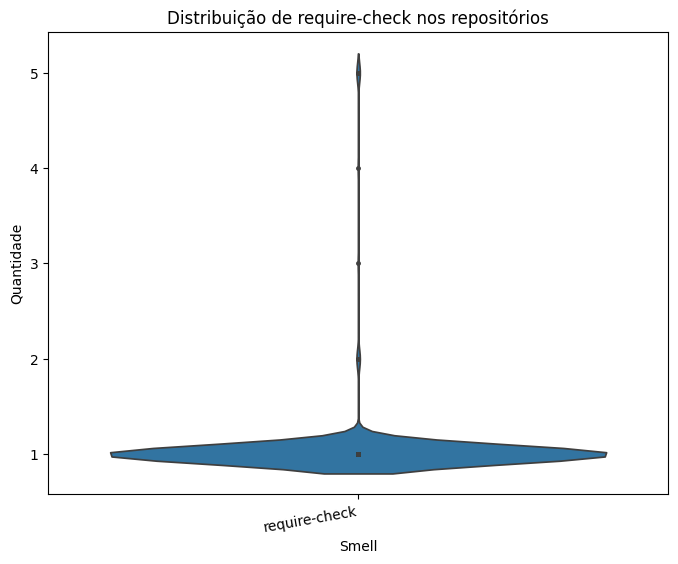

/tmp/ipykernel_29508/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


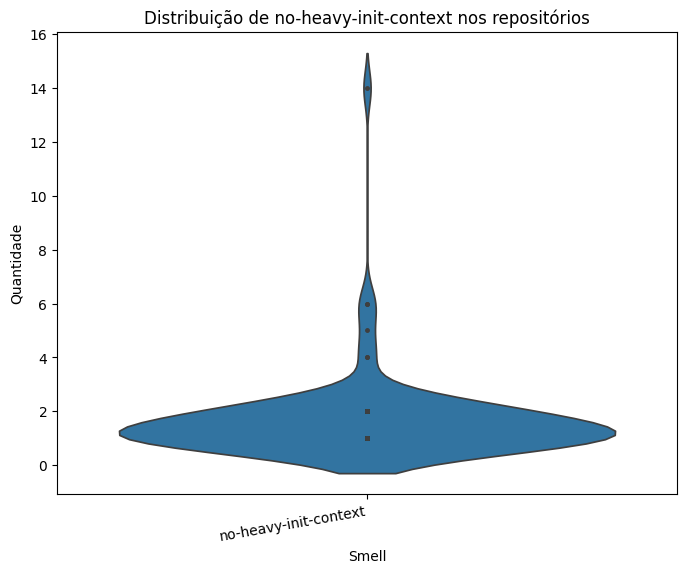

In [38]:
# Melt the DataFrame to long format for plotting
df_melted = df.melt(value_vars=violation_cols, var_name='Smell Type', value_name='Violation Count')
df_melted = df_melted[df_melted['Violation Count'] > 0]

# Get the top 4 smells based on total occurrences
top_4_smells = smell_counts.head(4).index.tolist()

for smell_type in top_4_smells:
    df_smell = df_melted[df_melted['Smell Type'] == smell_type]
    clean_name = smell_type.replace('k6-performance/', '').replace('/', '_')

    if not df_smell.empty:
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.violinplot(x='Smell Type', y='Violation Count', data=df_smell, inner='points', ax=ax)
        ax.set_title(f'Distribuição de {clean_name} nos repositórios')
        ax.set_xlabel('Smell')
        ax.set_ylabel('Quantidade')
        plt.xticks(rotation=10, ha='right')
        ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])
        # plt.tight_layout()

        # Salvar antes de mostrar
        out_file = os.path.join(IMG_OUTPUT_FOLDER, f'violin_{clean_name}.png')
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)
    else:
        print(f"No violations found for {clean_name}")

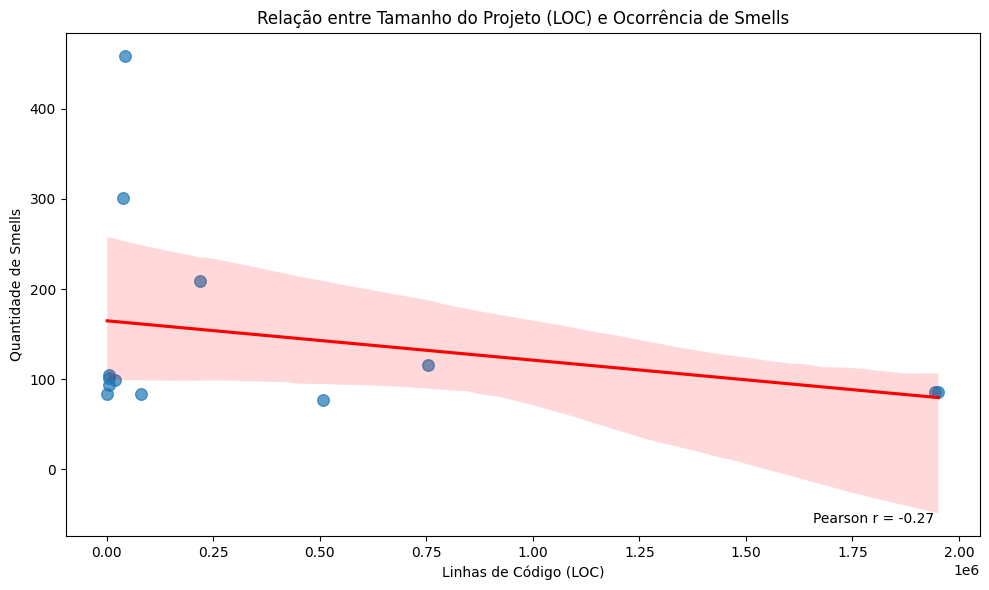

In [55]:
import numpy as np
import seaborn as sns
import pandas as pd
import os

import matplotlib.pyplot as plt

# load processed repo info (contains LOC)
proc = pd.read_csv('output/processed_k6_repos.csv')
proc.columns = proc.columns.str.lower().str.strip()

# try to detect repository and loc columns
repo_col = next((c for c in proc.columns if 'repo' in c or 'reposit' in c), None)
loc_col = next((c for c in proc.columns if 'loc' in c or 'line' in c), None)
if repo_col is None or loc_col is None:
    raise ValueError(f"Não foi possível identificar colunas de repositório/loc no arquivo. Cols encontradas: {proc.columns.tolist()}")

# normalize repository names and LOC values
proc[repo_col] = proc[repo_col].astype(str).str.strip()
proc[loc_col] = proc[loc_col].astype(str).str.replace(r'[^0-9]', '', regex=True).replace('', np.nan).astype(float)

# if the file has multiple rows per repo, aggregate LOC by repo (sum)
proc_loc = proc.groupby(repo_col, dropna=False)[loc_col].sum().reset_index().rename(columns={loc_col: 'loc'})

# prepare violations dataframe (violations_by_repo exists in notebook)
violations_df = violations_by_repo.reset_index().rename(columns={'repositório': repo_col, 'total_violations': 'total_violations'})

# merge LOC with violations
merged = pd.merge(violations_df, proc_loc, on=repo_col, how='left')

# drop missing LOC or zero LOC
merged = merged.dropna(subset=['loc'])

# plot scatter with regression line
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='loc', y='total_violations', data=merged, scatter_kws={'s':70, 'alpha':0.7}, line_kws={'color':'red'}, ax=ax)
ax.set_xlabel('Linhas de Código (LOC)')
ax.set_ylabel('Quantidade de Smells')
ax.set_title('Relação entre Tamanho do Projeto (LOC) e Ocorrência de Smells')

# show Pearson correlation in the plot
corr = merged['loc'].corr(merged['total_violations'])
ax.text(0.95, 0.02, f'Pearson r = {corr:.2f}', transform=ax.transAxes, ha='right', va='bottom', fontsize=10)

plt.tight_layout()
os.makedirs(IMG_OUTPUT_FOLDER, exist_ok=True)
out_path = os.path.join(IMG_OUTPUT_FOLDER, 'scatter_loc_violations.png')
fig.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

In [40]:
# Filter the original DataFrame to include only the top repositories with the most violations
top_repos = violations_by_repo.index
df_top_repos = df[df['repositório'].isin(top_repos)]

# Display the filtered DataFrame
display(df_top_repos)

,repositório,arquivo,k6-performance/no-heavy-init-context,k6-performance/no-heavy-init-context_loc,k6-performance/require-check,k6-performance/require-check_loc,k6-performance/require-tags,k6-performance/require-tags_loc,k6-performance/require-thresholds,k6-performance/require-thresholds_loc,total_violations
301,lucascnasc/k6-petstore,aulas/aula26.js,0,,0,,0,,0,,0
302,lucascnasc/k6-petstore,aulas/aula17.js,0,,0,,2,14:27; 22:27,0,,2
303,lucascnasc/k6-petstore,breakpoint/store/get_store_inventory.js,0,,1,13:1,0,,1,4:14,2
304,lucascnasc/k6-petstore,smoke/store/get_store_inventory.js,0,,0,,0,,1,4:14,1
305,lucascnasc/k6-petstore,load/user/post_user_createwitharray.js,0,,1,21:1,0,,1,4:14,2
...,...,...,...,...,...,...,...,...,...,...,...
3001,spryker/commerce-k6-performance-tests,src/tests/product-management/b4_product_create...,0,,0,,0,,1,28:14,1
3002,spryker/commerce-k6-performance-tests,src/tests/product-search/sapi2_product_search_...,0,,0,,0,,1,24:14,1
3003,spryker/commerce-k6-performance-tests,src/tests/product-details/sapi3_product_detail...,0,,0,,0,,1,23:14,1
3004,spryker/commerce-k6-performance-tests,src/tests/product/sapi12_concrete_product_all_...,0,,0,,0,,1,25:14,1


In [41]:
# Function to identify outliers using IQR
def identify_outliers(df, smell_col):
    Q1 = df[smell_col].quantile(0.25)
    Q3 = df[smell_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[smell_col] < lower_bound) | (df[smell_col] > upper_bound)]
    return outliers[['repositório', 'arquivo', smell_col]].rename(columns={smell_col: 'violation_count'})

# Identify and display outliers for each smell type in df_top_repos
for smell_col in violation_cols:
    outliers_df = identify_outliers(df_top_repos[df_top_repos[smell_col] > 0], smell_col) # Only consider rows with violations for outlier detection
    if not outliers_df.empty:
        print(f"Outliers for {smell_col.replace('k6-performance/', '')}:")
        display(outliers_df)
    else:
        print(f"No outliers found for {smell_col.replace('k6-performance/', '')}")

No outliers found for no-heavy-init-context
No outliers found for require-check
Outliers for require-tags:


,repositório,arquivo,violation_count
1097,criscarlolm/k6-kubernetes-aws-loadtest,eks/js/tcm-6926-browser-regression.js,26
1147,criscarlolm/k6-kubernetes-aws-loadtest,eks/js/tcm-6936-case-posting-module.js,15
1169,criscarlolm/k6-kubernetes-aws-loadtest,eks/js/test-prod-email.js,66
1950,petechain23/k6,05-omni_modularize_2/draft/edit.js,52
1985,petechain23/k6,03-omni/inventory.js,113
2012,petechain23/k6,05-omni_modularize_2/draft/performance.js,69
2396,firmansyah-github/quarkus-generated-test,src/main/k6/factor.all.k6.collection.js,98
2815,nicolevanderhoeven/k6-scripts,ecommerce-tag.js,44
2817,nicolevanderhoeven/k6-scripts,ecommerce-group.js,44
2828,nicolevanderhoeven/k6-scripts,ecommerce/homepage.js,45


No outliers found for require-thresholds
